In [1]:
import numpy as np
import numpy
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from nbodykit.cosmology import Cosmology, EHPower, Planck15

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [28]:
sys.path.append('../code/utils/')
import tools
# from background import *
# from tfpmdev import *
# from tfpmfuncsdev import *
from fpmfuncs import *
from fpm import *
from pmconfig import Config
sys.path.append('../code/flowpm/')
from background import *
from tfpm import *
from tfpmfuncs import *


In [29]:
state = fastpm()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Step F 0.1000 - (0.1000) -> 0.1000 S 0.1000 P 0.1000 F 0.1000
Step K 0.1000 - (0.1000) -> 0.1803 S 0.1000 P 0.1803 F 0.1000
Step D 0.1000 - (0.1803) -> 0.1803 S 0.1803 P 0.1803 F 0.1000
Step D 0.1803 - (0.1803) -> 0.3250 S 0.3250 P 0.1803 F 0.1000
Step F 0.1000 - (0.3250) -> 0.3250 S 0.3250 P 0.1803 F 0.3250
Step K 0.1803 - (0.3250) -> 0.3250 S 0.3250 P 0.3250 F 0.3250
Step K 0.3250 - (0.3250) -> 0.4228 S 0.3250 P 0.4228 F 0.3250
Step D 0.3250 - (0.4228) -> 0.4228 S 0.4228 P 0.4228 F 0.3250
Step D 0.4228 - (0.4228) -> 0.5500 S 0.5500 P 0.4228 F 0.3250
Step F 0.3250 - (0.5500) -> 0.5500 S 0.5500 P 0.4228 F 0.5500
Step K 0.4228 - (0.5500) -> 0.5500 S 0.5500 P 0.5500 F 0.5500
Step K 0.5500 - (0.5500) -> 0.6529 S 0.5500 P 0.6529 F 0.5500
Step D 0.5500 - (0.6529) -> 0.6529 S 0.6529 P 0.6529 F 0.5500
Step D 0.6529 - (0.6529) -> 0.7750 S 0.7750 P 0.6529 F 0.5500
Step F 0.5500 - (0.7750) -> 0.7750 S 0.7750 P 0.6529 F 0.7750
Step K 0.6529 - (0.7750) -> 0.7750 S 0.7750 P 0.7750 F 0.7750
Step K 0

# Check lptz0

In [5]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32, symmetric=False)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: mode argument is deprecated, use type


In [7]:
lptdisp = lptz0(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# #
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
print(tlptmesh, tlptpos)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos, tflptmesh = sess.run([tlptpos, tlptmesh])

In [ ]:
tflptpos-lptpos

In [ ]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))
ax = axar[0]
im = ax[0].imshow(linear[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Linear')
im = ax[1].imshow((lptmesh-tflptmesh)[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Difference 2LPT')
ax = axar[1]
im = ax[0].imshow(tflptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF 2LPT')
im = ax[1].imshow(lptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu 2LPT')



#### Checkgrad

In [ ]:
gindex = [0, 1, 1]
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
print(tlptmesh, tlptpos)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)
grad = tf.gradients(tlptmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tflptpos, tflptmesh = sess.run([grad, tlptpos, tlptmesh])

In [ ]:
# #
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)
grad = tf.gradients(tlptmesh, tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos2, tflptmesh2 = sess.run([tlptpos, tlptmesh])

In [ ]:
(tflptmesh2 - tflptmesh)[tuple(gindex)]/dx, tgrad[0][tuple(index)]

# FastPM

In [12]:
a0, a1 = conf['stages'][0], conf['stages'][1]
ah = (a0*a1)**0.5


### lpt IC

In [ ]:
# #
statelpt = solver.lpt(lineark, grid, a0, order=2)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstatelpt = sess.run(tflptic)
# tfstatelpt = ttmp.copy()

In [ ]:
(tfstatelpt[0])/ statelpt.X

In [ ]:
(tfstatelpt[0]-grid)/ statelpt.S

In [ ]:
(tfstatelpt[1])/ statelpt.V, (tfstatelpt[1])/ statelpt.P

In [ ]:
(tfstatelpt[2])/ statelpt.F

#### Checkgrad

In [ ]:
gindex = [1, 1]
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
grad = tf.gradients(tflptic[0][gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tlptic = sess.run([grad, tflptic])

In [ ]:
gindex = [1, 1]
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
grad = tf.gradients(tflptic[0][gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tlptic2 = sess.run([grad, tflptic])

In [ ]:
tgrad[0][tuple(index)]

In [ ]:
(tlptic2[0][tuple(gindex)] - tlptic[0][tuple(gindex)])/dx

### Kick

In [ ]:
### Example to play with the scatter

# npart = int(5) #no.of particles
# state = tf.zeros((3, npart, 3))
# indices = tf.constant([[0]])
# updates = tf.expand_dims(tf.constant(np.arange(npart*3).reshape(npart, 3)),axis=0)
# shape = state.shape
# #trying to update channel 0, i.e. first index of state

# print(indices)
# print(updates)
# print(shape)

# state = tf.scatter_nd(indices, updates, shape)
# print('state')
# with tf.Session() as sess:
#     print(sess.run(state[0]))

In [ ]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['F'] = ah
solver.nbodystep.Kick(state, a0, ah, a1)

# tfstate = []
# X, P, F
##
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run([tf.rank(tfstate), tf.rank(tfstate.shape)]))
    tfstate = sess.run(tfkicked)

In [ ]:
ii = 1
tfstate[ii] / tfstatelpt[ii], 
tfstate[ii] / state.P

#### Checkgrad

In [ ]:
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfkicked = tfKick(tflptic, a0, ah, a1,  conf)
grad = tf.gradients(tfkicked[1][gindex], tlinear)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tkicked, tlptic = sess.run([grad, tfkicked, tflptic])
#     tkicked, tlptic = sess.run([tfkicked, tflptic])

In [ ]:
gindex = [1, 1]
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfkicked = tfKick(tflptic, a0, ah, a1,  conf)
grad = tf.gradients(tfkicked[1][gindex], tlinear)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad2, tkicked2, tlptic2 = sess.run([grad, tfkicked, tflptic])


In [8]:
print(tgrad[0][tuple(index)])

NameError: name 'tgrad' is not defined

In [37]:
for ii in range(3):
    print((tkicked2[ii][tuple(gindex)] - tkicked[ii][tuple(gindex)])/dx)
#     print(tkicked2[ii][tuple(gindex)])


0.018167495727539062
0.011044740676879883
0.007902085781097412


### Drift

In [38]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [39]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['P'] = ah
solver.nbodystep.Drift(state, a0, ah, a1)

# #
tfkicked = tfDrift(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [40]:
ii = 0
#tfstate[ii] / tfstatelpt[ii], 
tfstate[ii] / state.X

array([[0.9963278 , 0.9994952 , 1.0004636 ],
       [0.9967734 , 0.99955726, 1.000001  ],
       [0.9991543 , 0.9899032 , 0.99998516],
       ...,
       [1.0000005 , 1.0000005 , 0.99999994],
       [1.0000006 , 1.0000006 , 1.0000007 ],
       [1.000001  , 1.000001  , 1.000001  ]], dtype=float32)

### Force

In [41]:
# #
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
delk = solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfForce(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)
    
#     tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
# tfforced = tfForce(tflptic, a0, ah, a1, conf)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     ttmp0, ttmp1 = sess.run([tfforced, tflptic])

In [42]:
statelpt.F/tfstatelpt[2]

array([[1.0029246 , 1.0004933 , 0.9995752 ],
       [1.0030539 , 1.0004253 , 0.9999895 ],
       [1.0008466 , 1.0167211 , 1.0001279 ],
       ...,
       [0.9998716 , 0.9999437 , 1.0000004 ],
       [0.9999452 , 0.99996144, 1.0000223 ],
       [1.0006272 , 1.0003211 , 1.0001202 ]], dtype=float32)

In [43]:
ii = 2
tfstate[2] / state.F

array([[0.9978576 , 0.9988102 , 1.0007216 ],
       [0.9987032 , 0.999365  , 1.0000432 ],
       [0.9993994 , 0.99812824, 0.99986583],
       ...,
       [0.99856657, 1.0000198 , 0.9999995 ],
       [1.0017841 , 1.0000608 , 0.9999481 ],
       [0.99936223, 0.99976146, 0.9997681 ]], dtype=float32)

# Put it all together

In [129]:
conf = Config(bs=400, nc=128, seed=100)
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm
a0, a1 = conf['stages'][0], conf['stages'][1]
ah = (a0*a1)**0.5

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
# kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
# gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32, symmetric=False)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
conf['grid'] = grid
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: mode argument is deprecated, use type


In [132]:
import fpm, fpmfuncs

In [133]:
# # %%timeit 
lineark = linear.r2c()
state = solver.lpt(lineark, grid, a0, order=2)
solver.nbody(state, leapfrog(conf['stages']))
meshpm = pm.paint(state.X)

state = fpm.lptz0(lineark, grid)
meshlpt = pm.paint(state)


# %%timeit 
# lineark = linear.r2c()
# state = solver.lpt(lineark, grid, a0, order=2)
# solver.nbody(state, leapfrog(conf['stages']))
# meshpmor0 = pm.paint(state.X)

# state = fpm.lptz0(lineark, grid)
# meshlptor0 = pm.paint(state)

In [92]:
import fpm, fpmfuncs

In [89]:
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     tfmeshpm , tfstatepm = sess.run([tfmesh, tfstate])


In [90]:
# tfmesh = tf.zeros((nc, nc, nc))
# tfmesh = cic_paint(tfmesh, tf.multiply(tfstatepm[0], nc/bs), weight=tf.ones(nc**3))

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     tfmeshpm = sess.run(tfmesh)

# meshpm = pm.paint(state.X)

Text(0.5, 1.0, 'Difference')

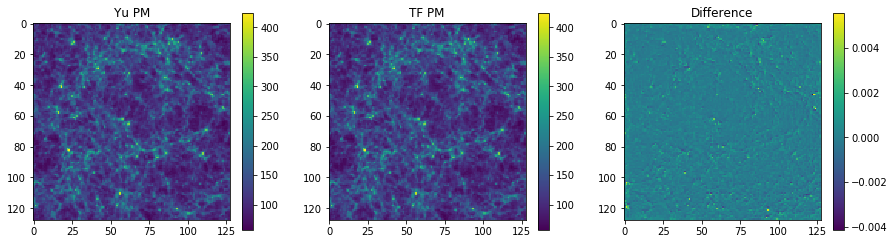

In [134]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Yu PM')
im = ax[1].imshow(tfmeshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('TF PM')
im = ax[2].imshow((meshpm-tfmeshpm)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')


In [137]:
truelin = BigFileMesh('/project/projectdirs/astro250/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step_B2/mesh/', 's').paint()
truefin = BigFileMesh('/project/projectdirs/astro250/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step/mesh/', 'd').paint()
truefinfpm = BigFileMesh('/project/projectdirs/astro250/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step_fpm/mesh/', 'd').paint()
truefinlpt = BigFileMesh('/project/projectdirs/astro250/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step_LPT/mesh/', 'd').paint()
truefin1 = BigFileMesh('/project/projectdirs/astro250/chmodi/cosmo4d/data/z00/L0400_N0128_S0100_05step_B1/mesh/', 'd').paint()


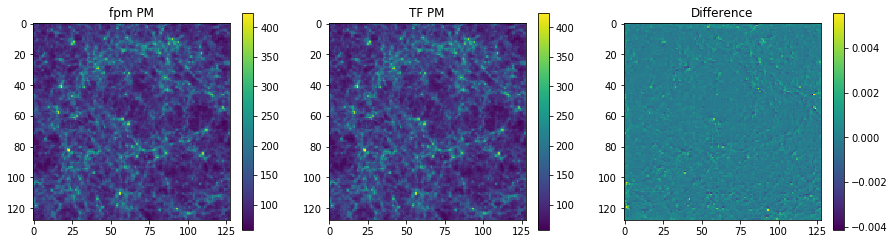

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


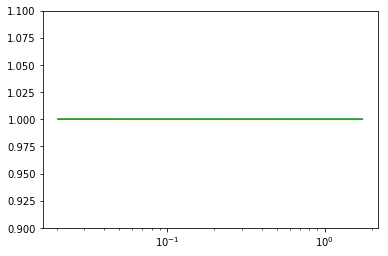

In [143]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(truefinfpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('fpm PM')
im = ax[1].imshow(tfmeshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('TF PM')
im = ax[2].imshow((truefinfpm-tfmeshpm)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
plt.show()


k, p1 = tools.power(truefinfpm, boxsize=bs)
k, p2 = tools.power(tfmeshpm, boxsize=bs)
k, px = tools.power(truefinfpm, tfmeshpm, boxsize=bs)
plt.semilogx(k, p2/p1, 'C2', label='TFPM-fpm')
plt.semilogx(k, px/(p2*p1)**0.5, 'C2')
plt.ylim(0.9, 1.1)
plt.show()


Text(0.5, 1.0, 'Difference')

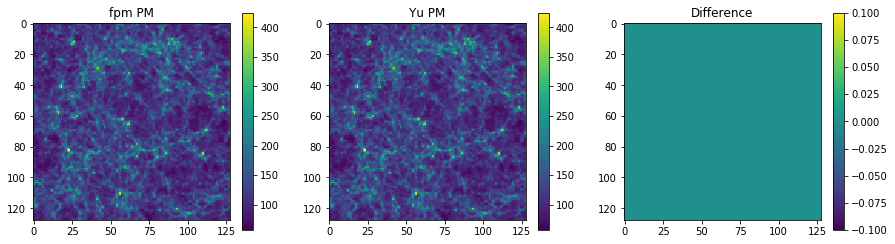

In [136]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(truefinfpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('fpm PM')
im = ax[1].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu PM')
im = ax[2].imshow((truefinfpm-meshpm)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')


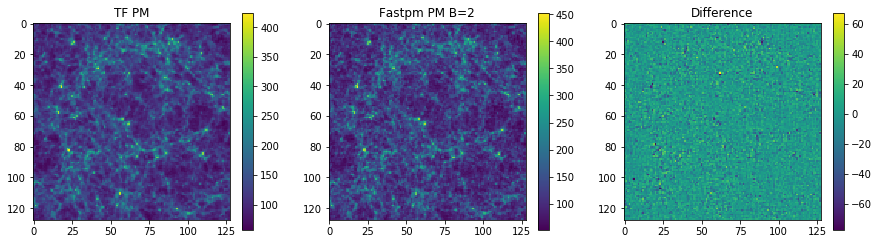

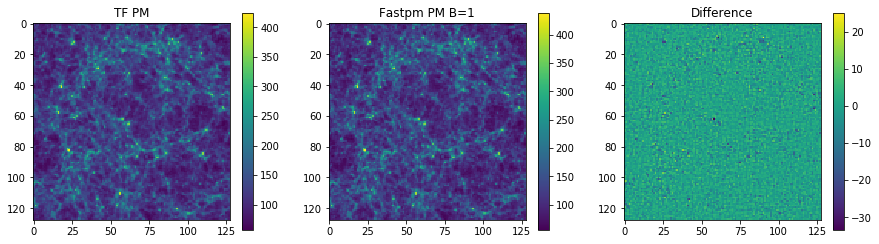

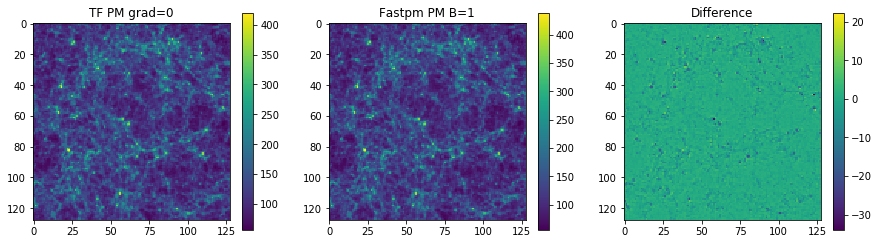

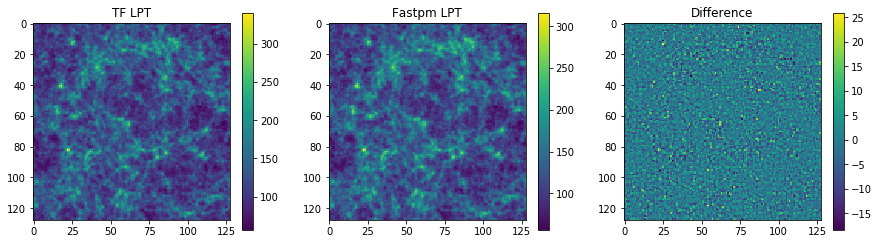

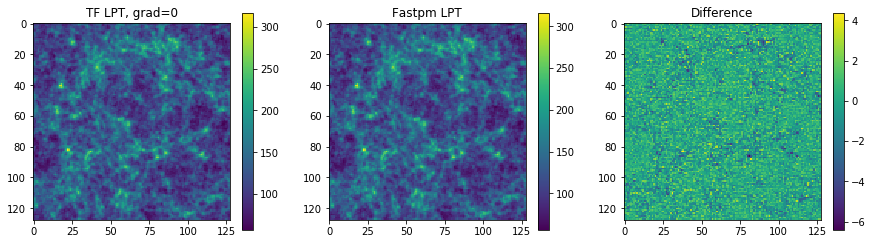

In [138]:

fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF PM')
im = ax[1].imshow(truefin[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Fastpm PM B=2')
im = ax[2].imshow((truefinfpm-truefin)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
plt.show()



fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF PM')
im = ax[1].imshow(truefin1[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Fastpm PM B=1')
im = ax[2].imshow((truefinfpm-truefin1)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
plt.show()



fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpmor0[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF PM grad=0')
im = ax[1].imshow(truefin1[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Fastpm PM B=1')
im = ax[2].imshow((meshpmor0-truefin1)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
plt.show()


fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshlpt[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF LPT')
im = ax[1].imshow(truefinlpt[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Fastpm LPT')
im = ax[2].imshow((meshlpt-truefinlpt)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
plt.show()


fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshlptor0[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF LPT, grad=0')
im = ax[1].imshow(truefinlpt[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Fastpm LPT')
im = ax[2].imshow((meshlptor0-truefinlpt)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
plt.show()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__ma

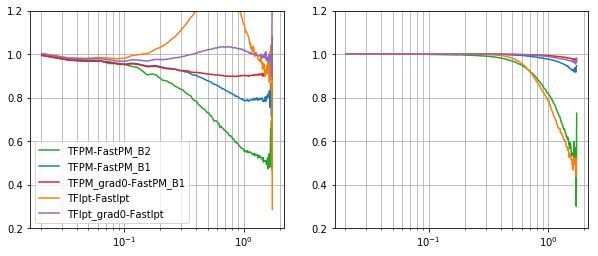

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))


k, p1 = tools.power(truefin, boxsize=bs)
k, p2 = tools.power(meshpm, boxsize=bs)
k, px = tools.power(truefin, meshpm, boxsize=bs)
ax[0].semilogx(k, p2/p1, 'C2', label='TFPM-FastPM_B2')
ax[1].semilogx(k, px/(p2*p1)**0.5, 'C2')

k, p1 = tools.power(truefin1, boxsize=bs)
k, p2 = tools.power(meshpm, boxsize=bs)
k, px = tools.power(truefin1, meshpm, boxsize=bs)
ax[0].semilogx(k, p2/p1, 'C0', label='TFPM-FastPM_B1')
ax[1].semilogx(k, px/(p2*p1)**0.5, 'C0')

k, p1 = tools.power(truefin1, boxsize=bs)
k, p2 = tools.power(meshpmor0, boxsize=bs)
k, px = tools.power(truefin1, meshpmor0, boxsize=bs)
ax[0].semilogx(k, p2/p1, 'C3', label='TFPM_grad0-FastPM_B1')
ax[1].semilogx(k, px/(p2*p1)**0.5, 'C3')

k, p1 = tools.power(truefinlpt, boxsize=bs)
k, p2 = tools.power(meshlpt, boxsize=bs)
k, px = tools.power(truefinlpt, meshlpt, boxsize=bs)
ax[0].semilogx(k, p2/p1, 'C1', label='TFlpt-Fastlpt')
ax[1].semilogx(k, px/(p2*p1)**0.5, 'C1')

k, p1 = tools.power(truefinlpt, boxsize=bs)
k, p2 = tools.power(meshlptor0, boxsize=bs)
k, px = tools.power(truefinlpt, meshlptor0, boxsize=bs)
ax[0].semilogx(k, p2/p1, 'C4', label='TFlpt_grad0-Fastlpt')
ax[1].semilogx(k, px/(p2*p1)**0.5, 'C4')

for axis in ax: axis.grid(which='both')
for axis in ax: axis.set_ylim(0.2, 1.2)
ax[0].legend()

### Checkgrad

In [50]:
tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstate[0], nc/bs), weight=tf.ones(nc**3))
grad = tf.gradients(tfmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tgrad, tfmeshpm , tfstatepm = sess.run([grad, tfmesh, tfstate])


In [51]:
gindex = [1, 1, 1]
index = [1, 1, 1]
dx = 0.01
dxmesh = np.zeros_like(linear[...])
dxmesh[tuple(index)] +=dx

tlinear = tf.constant(linear[...]+dxmesh)
tlineark = tf.multiply(tf.spectral.fft3d(tf.cast(tlinear, tf.complex64)), 1/nc**3)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstate[0], nc/bs), weight=tf.ones(nc**3))
grad = tf.gradients(tfmesh[gindex], tlinear)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfmeshpm2 , tfstatepm2 = sess.run([tfmesh, tfstate])
    

In [52]:
print(tgrad[0][tuple(index)])

0.047482103


In [53]:
(tfmeshpm2[tuple(gindex)] - tfmeshpm[tuple(gindex)])/dx

0.03806948661804199

# Reconstruction